### Questions:
- Is our assumption (used in the simulation analysis) accurate?
    - Assumption: "If the gas price is greater than the minimum gas price in a block, the transaction gets included."
- Which gas selection method (`recommended`, `boosted10`, `hybrid`) works best?
- Which gas selection method is most expensive/least expensive? (i.e. cost/benefit analysis)
- Also: how different are the methods?

**ALSO**: update our assumption: what percentile (of gas prices in a block $B$) do we need to have in order to be included in $B$ (with a decent amount of confidence)?

In [1]:
import pandas as pd
#pd.options.mode.chained_assignment = None  # default='warn'

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("white")
API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

In [2]:
%load_ext dotenv
%dotenv
import _utils

### Get data

In [3]:
#df = _utils.load_live_test_data()
#df = _utils.validate(df, pbar=True)
#df.to_csv('live_test_data.csv', index=False)

In [4]:
df = pd.read_csv("live_test_data.csv")
_utils.convert_to_int(df)

## remove outliers
df = df[~df.hash.isna()]
# remove earlier fuck ups
df = df[df['submitTimestamp'] >= 475_000]
# remove outliers due to pending txns b/c of wrong nonce
df = df[~df['confirmBlockNumber'].isin([11792088, 11792615, 11792612])]
df.reset_index(inplace=True, drop=True)
df

,confirmBlockNumber,confirmTimestamp,confirmations,createTimestamp,currentBlockTimestamp,hash,method,recommendedGasPrice,sampleGasPrice,submitBlockNumber,submitTimestamp,usedGasPrice
0,11791967,1612470548,2,1612470545,NaN,0xbe34b4815688c8bba346ff2444835cd677dbc51372b8...,boosted10,225000000000,320000000000,11791965,1612470522,247500000000
1,11792037,1612471370,2,1612471364,NaN,0x5487ab5fb6355efe0176fe67a7904b81a5f32bfc6ace...,boosted10,158400000000,287000000000,11792035,1612471340,174240000000
2,11792044,1612471421,1,1612471425,NaN,0x88470057bfdb8bdaf602349bea7fcc7094b7eebed0f1...,boosted10,142000000000,335781250000,11792043,1612471410,156200000000
3,11792050,1612471482,2,1612471485,NaN,0xe6b53e1443cba00f47959122346da5ec66affcbd24f1...,boosted10,163900000000,202000000000,11792048,1612471454,180290000000
4,11792060,1612471564,3,1612471544,NaN,0xb1b3ee02f638e81cca64b99f71853ab77e10c51c4d74...,boosted10,149000000000,149000000000,11792057,1612471538,163900000000
...,...,...,...,...,...,...,...,...,...,...,...,...
707,11794156,1612499961,3,1612499960,1.612500e+09,0x59a6a2192234545ed9b127a38e1a814fb555035db0f1...,recommended,150960000000,216000000000,11794153,1612499930,150960000000
708,11794166,1612500021,2,1612500012,1.612500e+09,0x17efecc702bc0cfc052f851b9040a9f3ed2837012c4c...,recommended,142000000000,122000000000,11794164,1612500004,142000000000
709,11794173,1612500114,5,1612500080,1.612500e+09,0x786f7a7d2c991ac9137b3c258d06b47dd6fa03828177...,recommended,141000000000,122000000000,11794168,1612500045,141000000000
710,11794185,1612500247,1,1612500252,1.612500e+09,0xe8a90627ae8b4a3cf67054759c4f0b78554f80f3d844...,recommended,141000000000,146000000000,11794184,1612500244,141000000000


#### Get historical data

In [5]:
# get historical data
df_hist = _utils.get_historical_transaction_data()
df_hist.head()

,blockNum,txnHash,gasPrice
131080,11791964,0x6a5c92893c005ac9c0b1430e3cf74b1c9f94d0ddfbb1...,469500000000
131201,11791964,0x665c4f222f6d596e89a2a831033953be138214e677c9...,285000000000
131202,11791964,0xde01dd6b1c81ea6a7aafb46003b53db9d7352b7b57c6...,284000000000
131203,11791964,0x5d833a4887ef5a864e0f1652220b6822cdae477d3ac8...,278000000000
131204,11791964,0x907509ef0890117373a018b99437fa42c43f34f5533b...,277000000000


# What does it take to get mined?

For a given txn $t$, we want to compare the block where $t$ was mined with the blocks where $t$ wasn't mined.

### Constructing our data sets

For a given transaction $t$, we look at (1) the block in which it was **mined** (assuming it was mined at all) and (2) the blocks in which $t$ was **unmined**. Therefore, we construct a data set consisting of:

1. Mapping of txn $t$ to the block $b_t$ in which $t$ was mined.
2. Mapping of txn $t$ to an array $\bar{B_t}$ of blocks where $t$ was unmined.

**Notes**
- We define blocks in which $t$ was unmined as: all the blocks that were mined once $t$ was in the mempool, but before $t$ itself was confirmed/mined *or* before it was replaced with a txn with the same nonce.
- Someone told me the Ethereum network has a txn propagation time of ~2 seconds. I haven't been able to find more "authoratative" numbers thus far, but based on personal experience, 2 seconds seems reasonable.
- We add a 10 second delay (i.e. we check for blocks mined 10 seconds after $t$ was submitted) because we assume the txn wouldn't get mined in whatever block is currently being mined (recall: block time in Ethereum is ~10-20 seconds).

In [6]:
df_mined = _utils.get_mined_df(df, pbar=False)
df_mined.head(10)

,hash,usedGasPrice,confirmations,mined_block,unmined_blocks
0,0xbe34b4815688c8bba346ff2444835cd677dbc51372b8...,247500000000,2,11791967,[]
1,0x5487ab5fb6355efe0176fe67a7904b81a5f32bfc6ace...,174240000000,2,11792037,[]
2,0x88470057bfdb8bdaf602349bea7fcc7094b7eebed0f1...,156200000000,1,11792044,[]
3,0xe6b53e1443cba00f47959122346da5ec66affcbd24f1...,180290000000,2,11792050,[]
4,0xb1b3ee02f638e81cca64b99f71853ab77e10c51c4d74...,163900000000,3,11792060,[]
5,0x3ff6877cf17f5799dfbd030791aee71cee78b41bfc59...,180290000000,4,11792068,"[11792066, 11792067]"
6,0x6ea449161d9648847bbdaaa09f3d71c2a35098afff31...,210100000000,5,11792073,"[11792070, 11792071, 11792072]"
7,0x300eb9fe36ca17f8a1ae8d9a9a5705c519cabfa7d926...,322300000000,2,11792091,[]
8,0x42dc1aec13372f0b0e46157e31c563c628749ee8ebd2...,165000001481,4,11792098,"[11792096, 11792097]"
9,0xae556a15072bfa8307e5bc6377055fe780247837ad25...,165000000000,3,11792101,[]


### Dataset sizes:

In [7]:
n_mined = df_mined.mined_block.dropna().shape[0]
print(f"# txns in \"mined\" dataset:\t{n_mined}")

flatten = lambda t: [item for sublist in t for item in sublist]
n_unmined = pd.Series(flatten(df_mined.unmined_blocks.tolist())).shape[0]
print(f"# txns in \"unmined\" dataset:\t{n_unmined}")

# txns in "mined" dataset:	712
# txns in "unmined" dataset:	151


### Comparing our gas prices to the other gas prices in the same block
We're interested in comparing our chosen gas price for a given transaction $t$ with the other gas prices in $b_t$ and $\bar{B_t}$.

In [8]:
df_percentiles = _utils.get_percentile_df(df_mined, df_hist, pbar=True)
df_percentiles

,hash,usedGasPrice,confirmations,mined_block,unmined_blocks,unmined_blocks_percentiles,mined_block_percentiles
0,0xbe34b4815688c8bba346ff2444835cd677dbc51372b8...,247500000000,2,11791967,[],[],7.17
1,0x5487ab5fb6355efe0176fe67a7904b81a5f32bfc6ace...,174240000000,2,11792037,[],[],23.45
2,0x88470057bfdb8bdaf602349bea7fcc7094b7eebed0f1...,156200000000,1,11792044,[],[],7.04
3,0xe6b53e1443cba00f47959122346da5ec66affcbd24f1...,180290000000,2,11792050,[],[],38.41
4,0xb1b3ee02f638e81cca64b99f71853ab77e10c51c4d74...,163900000000,3,11792060,[],[],39.33
...,...,...,...,...,...,...,...
707,0x59a6a2192234545ed9b127a38e1a814fb555035db0f1...,150960000000,3,11794156,[],[],43.40
708,0x17efecc702bc0cfc052f851b9040a9f3ed2837012c4c...,142000000000,2,11794166,[],[],26.63
709,0x786f7a7d2c991ac9137b3c258d06b47dd6fa03828177...,141000000000,5,11794173,[11794172],[19.91],60.94
710,0xe8a90627ae8b4a3cf67054759c4f0b78554f80f3d844...,141000000000,1,11794185,[],[],22.56


# Testing our hypothesis
How accurate is our hypothesis/assumption $A^*$ and can we update it to a more accurate one?

Hypothesis $A^*$: If a transaction $t$ had been submitted (i.e. was in the mempool) right before block $B_i$ had been mined, it would have gotten mined in the first block $B_j$, $j \ge i$ where: $$t_{gasPrice} > \min_{x \in B_j} x_{gasPrice}$$

That is, $t$ would have gotten mined in the first block containing some transaction $x$ with gas price strictly less than $t_{gasPrice}$.

Note: this assumption doesn't take into consideration mempool data, which it probably should, however it's not obvious how this information should be used or even whether gathering such information (when computing ideal gas price) is even feasible.

### Updating our hypothesis:
We would like to update our hypothesis along the lines of: how much higher does the gas price of $t$ need to be compared to the other txns in $B$ in order for us to *confidently* conclude that the inclustion of $t$ in $B$ is highly probable? 

More formally: we'd like to find some percentile $P_i$ such that if $t_{gasPrice}$ is the $P_i$ percentile of gas prices in $B$ then $t$ will get mined in $B$ (with some high probability $p$).

**Note**: This is useful because then we can continue running simulations on historical data (and be relatively confident in our results) rather than having to do costly live testing.

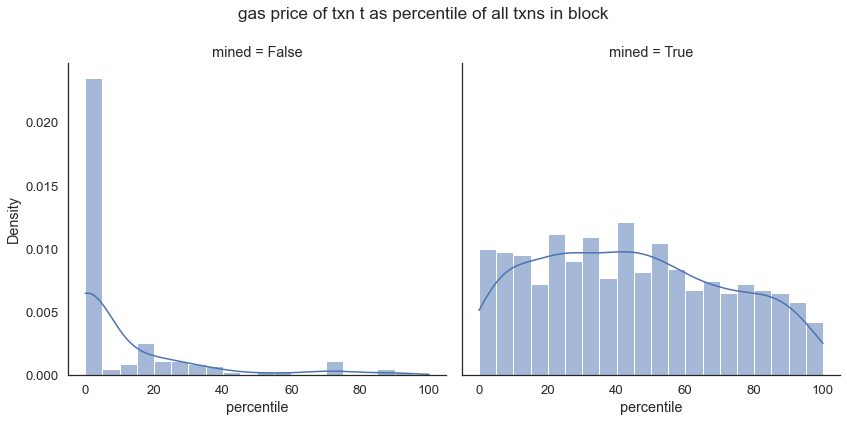

In [10]:
fg = sns.displot(
    df_percentile, x="percentile", col="mined",
    kind='hist', kde=True, stat="density",
    height=6, aspect=1, bins=20,
);
fg.fig.subplots_adjust(top=0.85)
fg.fig.suptitle('gas price of txn t as percentile of all txns in block');

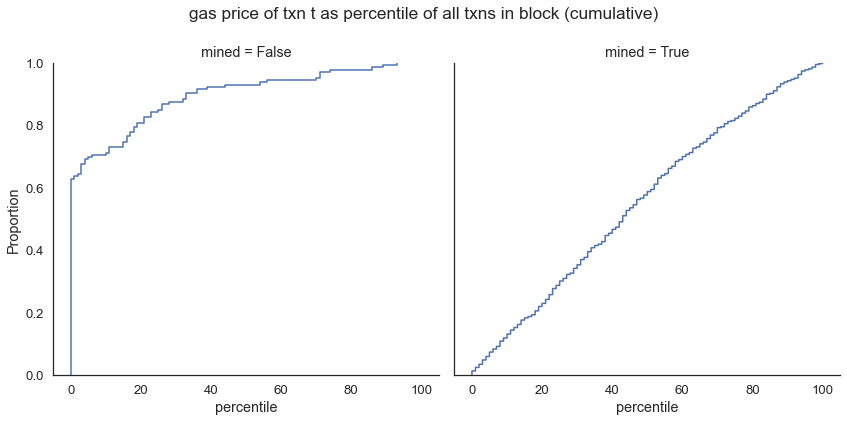

In [11]:
fg = sns.displot(
    df_percentile, x="percentile", col="mined",
    kind='ecdf', stat="proportion", 
    height=6, aspect=1,
);
fg.fig.subplots_adjust(top=0.85)
fg.fig.suptitle('gas price of txn t as percentile of all txns in block (cumulative)');

#### How many txns at 0 or 100 percentile?
That is, how often do we have a txn with gas price greater/less than *all* txns in a given block?

In [12]:
def percent(n):
    def percent_(x):
        if n in x.values:
            return x.value_counts().loc[n] / x.size
        return 0
    percent_.__name__ = f'percent_{n}'
    return percent_

res = df_percentile.groupby('mined').agg({'percentile': [percent(0), percent(100)]})
res = res.style.format("{:.1%}")
res

### Comments
- When $t$ is mined in $B$, it seems to be *equally likely* to be in any percentile; i.e it's equally likely that $t$ has a gas price that's in the $P_i$th percentile where $P_i \in (0, 100)$.
- In 63% of the cases where $t$ is *not mined* in some block $B$, $t$ has a gas price that *less* than all txns in $B$ (i.e. 0th percentile of $B$).

I think this would imply our assumption $A^*$ is decent. *However*, we see in our data that 37% of the time, a txn satisfying $A^*$ doesn't get mined.

**NOTE:** in order to update $A^*$, I'd ideally like to see a percentile in the unmined cumulative graph (above left) that leads to a sharp increase, however this isn't the case: after 0, we see a relatively smooth increase.

# STILL ROUGH WORK BELOW

## Updating the assumption

For a given txn $t$ and a given block $B$:

- Let $M$ = "$t$ is mined in block $B$"

- Let $P_i$ = "$t_{gasPrice}$ has a percentile rank of $P_i$ for gas prices in $B$"

Consider:

$$
\begin{align*}
P(M | P_i)
&=  \frac{P(P_i \cap M)}{P(P_i)}\\[1em]
&=  \frac{P(P_i) - P(P_i \cap \neg M)}{P(P_i)}\\[1em]
&= 1 - P(\neg M | P_i)\\
\end{align*}
$$

### Doing the computation
We only consider percentiles $P_i$ in:

$$[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]$$

In [13]:
##
## AT LEAST
##

def compute_m_given_p(p1, p2):
    
    # P_i & M
    count_pi_and_m = (df_percentile.mined & df_percentile.percentile.between(p1, p2)).value_counts().loc[True]
    #print(pi_and_m)
    # P_i
    count_pi = (df_percentile.percentile.between(p1, p2)).value_counts().loc[True]
    #print(pi)
    
    return count_pi_and_m, count_pi, 100 * count_pi_and_m / count_pi

inc = 25
pis = [[0, 0]] + [[x + 1, x + inc] for x in range(0, 100, inc)] + [[100, 100]]

result = []

for p1, p2 in pis:
    count_pi_and_m, count_pi, p = compute_m_given_p(p1, p2)
    result.append(p)
    if p1 == p2:
        print(f"[{p1}, {p2}]  \t{p:.1f}% \t\t({count_pi_and_m} / {count_pi})")
    else:
        print(f"({p1 - 1}, {p2}]  \t{p:.1f}% \t\t({count_pi_and_m} / {count_pi})")

[0, 0]  	9.8% 		(10 / 102)
(0, 25]  	86.5% 		(205 / 237)
(25, 50]  	94.4% 		(204 / 216)
(50, 75]  	96.0% 		(167 / 174)
(75, 100]  	97.7% 		(126 / 129)
[100, 100]  	100.0% 		(1 / 1)


In [14]:
result, pis

([9.803921568627452,
  86.49789029535864,
  94.44444444444444,
  95.97701149425288,
  97.67441860465117,
  100.0],
 [[0, 0], [1, 25], [26, 50], [51, 75], [76, 100], [100, 100]])